In [1]:
import os 
# os.environ['KERAS_BACKEND'] = 'theano'
import keras
print(keras.__version__)
from tensorflow import test
test.is_gpu_available()

Using TensorFlow backend.


2.0.2


True

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from keras.datasets import cifar10, mnist

In [4]:
(x_train, _), (x_test, y_test) = cifar10.load_data()
if x_train.ndim == 3:
    s = x_train.shape
    x_train = x_train.reshape((len(x_train), s[1], s[2], 1))
    x_test = x_test.reshape((len(x_test), s[1], s[2], 1))
original_img_size = x_train[0].shape
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)
print(x_train.shape, x_test.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal, ndimage, misc

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, Dropout, GaussianNoise
from keras.layers import Activation
from keras.layers import Conv2D, Deconv2D, MaxPooling2D, UpSampling2D
from keras.layers import Conv3D, UpSampling3D, MaxPooling3D
from keras.models import Model
from keras import regularizers
from keras import backend as K_backend
from keras import objectives

import models_basic

from keras_tqdm import TQDMNotebookCallback

from autoencoder import VAE_MNIST_0

In [12]:
class Autoencoder(models_basic.SaveableModel):
    """
    Base class for all-purpose autoencoder. VAE, CNN-AE, etc will be built off of this.

    Input -> Encoder -> Z Latent Vector -> Decoder -> Output
    """
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100, # size of minibatch
                 compile_decoder=False # create the decoder. Not necessary for every use case
                 ):
        self.model = None
        self.encoder = None
        self.decoder = None
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.compile_decoder = compile_decoder
        assert K_backend.image_dim_ordering() == 'tf', 'Cannot support Theano ordering! Use TF ordering! #tensorflowmasterrace'

        # input image dimensions
        self.input_shape = input_shape
        # self.data_shape = input_shape[1:] # Shape of a single sample
        if len(input_shape) == 4:
            self.img_rows, self.img_cols, self.img_stacks, self.img_chns = input_shape
        elif len(input_shape) == 3:
            self.img_rows, self.img_cols, self.img_chns = input_shape
        elif len(input_shape) == 2:
            self.img_rows, self.img_cols = input_shape
            self.img_chns = 1
        elif len(input_shape) == 1:
            self.img_rows = input_shape[0]  # todo: test this
        else:
            raise ValueError("Invalid input shape: {}".format(input_shape))

    def rollup_decoder(self, z, z_input, layers_list):
        """
        Takes a list of Keras layers and returns the decoder back-half and the standalone decoder model
        :param z: Layer corresponding to the latent space vector
        :param z_input: Layer corresponding to the decoder input
        :param layers_list: List of layers to roll up
        :return:
        """
        ae = AE_Dec()
        dc = AE_Dec()
        last_ae = z
        last_dc = z_input
        for i, layer in enumerate(layers_list):
            #             if i ==0:
            last_ae = layer(last_ae)
            if self.compile_decoder:
                last_dc = layer(last_dc)
        return last_ae, last_dc


class AE_Dec(object):
    """
    Dummy object for reasons I can't remember. This may be deprecated.
    """
    def __init__(self):
        pass


class VAE(Autoencoder):
    """
    Variational Autoencoder.
    """
    def __init__(self,
                 input_shape=(28, 28, 1),
                 latent_dim=2,  # Size of the encoded vector
                 batch_size=100,  # size of minibatch
                 epsilon_std=1.0, # This is the stddev for our normal-dist sampling of the latent vector
                 compile_decoder=False
                 ):
        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size,
                         compile_decoder=compile_decoder)
        # Necessary to instantiate this as instance variables such that they can be passed to the loss function (internally), since loss functions are
        # all of the form lossfn(y_true, y_pred)
        self.epsilon_std = epsilon_std
        self.z_mean = Dense(latent_dim)
        self.z_log_var = Dense(latent_dim)



    def sampling(self, args):
        """
        This is what makes the variational technique happen.
        :param args:
        :return:
        """
        # Forging our latent vector from the reparameterized mean and std requires some sampling trickery
        # that admittedly I do not understand in the slightest at this point in time
        z_mean, z_log_var = args
        batch_size = self.batch_size
        epsilon = K_backend.random_normal(shape=(batch_size, self.latent_dim),
                                          mean=0., stddev=self.epsilon_std)
        # We return z_mean + epsilon*sigma^2. Not sure why we use log var
        # Basically, create a random variable vector from the distribution
        # We are learning a distribution (mu, var) which represents the input
        return z_mean + K_backend.exp(z_log_var) * epsilon

    def vae_loss(self, x, x_decoded_mean):
        """
        Custom loss function for VAE. Uses Kullback-Leibler divergence.

        Notes from fchollet: binary_crossentropy expects a shape (batch_size, dim) for x and x_decoded_mean,
        so we MUST flatten these!
        :param x:
        :param x_decoded_mean:
        :return:
        """

        x = K_backend.flatten(x)
        x_decoded_mean = K_backend.flatten(x_decoded_mean)
        shape_coef = np.product(self.input_shape)
        xent_loss = shape_coef * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K_backend.mean(
            1 + self.z_log_var - K_backend.square(self.z_mean) - K_backend.exp(self.z_log_var), axis=-1)
        return xent_loss + kl_loss


class DiscVAE(VAE):
    """ Covolutional Discriminative VAE
     Discriminative Regularization for Generative Models
     """

    def __init__(self,
                 input_shape=(64, 64, 3),
                 latent_dim=256,  # Size of the encoded vector
                 n_classes=10,  # number of classes in dataset
                 batch_size=100,  # size of minibatch
                 n_stacks=3,  # Number of convolayers to stack, this boosts performance of the network dramatically
                 intermediate_dim=256,  # Size of the dense layer after convs
                 n_filters=64,  # Number of filters in the first layer
                 px_conv=3,  # Default convolution window size
                 dropout_p=0.1,  # Default dropout rate
                 epsilon_std=1.0,  # This is the stddev for our normal-dist sampling of the latent vector
                 compile_decoder=True,
                 ):

        # This is my original crossfire network, and it works. As such, it has apprentice marks all over
        # Reconstructing as-is before tinkering
        # Based heavily on https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder_deconv.py
        # and https://groups.google.com/forum/#!msg/keras-users/iBp3Ngxll3k/_GbY4nqNCQAJ

        super().__init__(input_shape=input_shape, latent_dim=latent_dim, batch_size=batch_size, epsilon_std=epsilon_std,
                         compile_decoder=compile_decoder)
        self.new_model(input_shape=input_shape, latent_dim=latent_dim, n_stacks=n_stacks)


    def new_model(self,
                  input_shape=(64,64,3),
                  latent_dim=256,
                  kern=3,
                  n_filtersX=32,
                  n_stacks=4,
                  dropout_p=0.2,
                  intermediate_dim=256):
        # Convolutional frontend filters as per typical convonets
        print(self.input_shape)

        core_width = input_shape[0] // 2**n_stacks # this will probably break horribly for shapes not power of 2
        n_filtersZ = n_filtersX * 2**(n_stacks-1)

        x_in = Input(self.input_shape, name='main_input')
        stack = x_in # bit of a hack so we can use a for loop here
        
        enc_list = [BatchNormalization()]

        # -> CONV/FC -> BatchNorm -> ReLu(or other activation) -> Dropout -> CONV/FC ->
        for i in range(n_stacks):
            enc_list.append(Conv2D(n_filtersX * 2 ** i, (kern, kern), padding='same', activation='relu', name='conv_{}a'.format(i)))
#             stack = BatchNormalization()(stack)
#             stack = Activation('relu')(stack)
            stack = Dropout(dropout_p)(stack)
            stack = Conv2D(n_filtersX * 2 ** i, (kern, kern), padding='same', activation='relu', name='conv_{}b'.format(i))(stack)
#             stack = BatchNormalization()(stack)
#             stack = Activation('relu')(stack)
            stack = Dropout(dropout_p)(stack)
            stack = MaxPooling2D(pool_size=(2,2))(stack)



        # Densely connected layer after the filters
        flat = Flatten()(stack)
        hidden_1 = Dense(intermediate_dim, activation='relu', name='intermezzo')(flat)

        # This is the Variational Autoencoder reparameterization trick
        z_mean = Dense(latent_dim)(hidden_1)
        z_log_var = Dense(latent_dim)(hidden_1)

        # Make these instance vars so X-Ent can use them. Probably a better way out there
        self.z_mean = z_mean
        self.z_log_var = z_log_var

#         # Part 2 of the reparam trick is sample from the mean-vec and std-vec (log_var). To do this, we utilize a
#         # custom layer via Lambda class to combine the mean and log_var outputs and a custom sampling function
#         # 'z' is our latent vector
        z = Lambda(self.sampling, output_shape=(latent_dim,), name='latent_z')([z_mean, z_log_var])
#         print(z.shape)

#         # This marks the end of the encoding portion of the VAE

#         # On to Decoder. we instantiate these layers separately so as to reuse them later
#         # e.g. for feeding in latent-space vectors, or (presumably) inspecting output

        output_shape = (None, core_width, core_width, n_filtersZ)

        decoder_hidden = Dense(intermediate_dim, activation='relu')
        decoder_upsample = Dense(n_filtersZ * core_width**2, activation='relu')


        decoder_reshape = Reshape(output_shape[1:])

        dec_list = [decoder_hidden, decoder_upsample, decoder_reshape]

        for i in range(n_stacks-1):
            dec_list.append(UpSampling2D((2,2)))
            dec_list.append(Deconv2D(n_filtersX * 2 ** (n_stacks-i-1), (kern, kern), padding='same', activation='relu', name='deconv_{}a'.format(i)))
            dec_list.append(BatchNormalization())
            dec_list.append(Activation('relu'))
            dec_list.append(Dropout(dropout_p))
            dec_list.append(Deconv2D(n_filtersX * 2 ** (n_stacks-i-1), (kern, kern), padding='same', activation='relu', name='deconv_{}b'.format(i)))
            dec_list.append(BatchNormalization())
            dec_list.append(Activation('relu'))
            dec_list.append(Dropout(dropout_p))
            
        dec_list.append(UpSampling2D((2,2)))
        dec_list.append(Conv2D(self.input_shape[2], (kern, kern), padding='same', activation='sigmoid', name='deconv_fin')) # trick to drop down to N channels from filters

#         # # FC uses Deconv, but another example uses UpSample layers. See Keras Api: Deconvolution2D
#         # decoder_deconv_1 = Deconv2D(n_filtersX, kern, kern, output_shape,
#         #                             border_mode='same', activation='relu')
#         # decoder_deconv_2 = Deconv2D(n_filtersX, kern, kern, output_shape,
#         #                             border_mode='same', activation='relu')
#         #
#         # # Some more reshaping, presumably I need to modify this in order to use different shapes
#         # output_shape = (None, 29, 29, n_filtersX)
#         #
#         # # more FC voodoo
#         # decoder_deconv_3_upsamp = Deconv2D(n_filtersX, 2, 2, output_shape, border_mode='valid', subsample=(2, 2),
#         #                                    activation='relu')
#         # decoder_mean_squash = Conv2D(self.img_chns, 2, 2, border_mode='same', activation='sigmoid', name='main_output')
#         #
#         #
#         # x_decoded_mean_squash = decoder_mean_squash

#         # layers_list = [decoder_hidden, decoder_upsample, decoder_reshape, decoder_deconv_1, decoder_deconv_2,
#         #                decoder_deconv_3_upsamp, decoder_mean_squash]

        decoder_input = Input(shape=(latent_dim,))

        # todo: better naming convention
        ae, dc = self.rollup_decoder(z, decoder_input, dec_list)

#         # if self.compile_decoder:
#         #     # FC: build a digit generator that can sample from the learned distribution
#         #     # todo: (un)roll this
#         #     _hid_decoded = decoder_hidden(decoder_input)
#         #     _up_decoded = decoder_upsample(_hid_decoded)
#         #     _reshape_decoded = decoder_reshape(_up_decoded)
#         #     _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
#         #     _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
#         #     _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
#         #     _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)

#         # Now we create the actual models. We also compile them automatically, this could be isolated later
#         # Primary model - VAE
        self.model = Model(x_in, ae)
        self.model.compile(optimizer='rmsprop', loss=self.vae_loss)


        # build a model to project inputs on the latent space
        self.encoder = Model(x_in, self.z_mean)
#         self.foo = Model(x_in, decoder_reshape)
        if 0:# self.compile_decoder:
            # reconstruct the digit pictures from latent space
            self.decoder = Model(decoder_input, dc)

    def fit_crossmodel(self, x_dict, y_dict, batch_size=None, nb_epoch=10, verbose=1, callbacks=[],
                       validation_split=0.,
                       validation_data=None, shuffle=True, class_weight=None, sample_weight=None):
        pass
        #     callbacks_history = self.crossmodel.fit(x_dict, y_dict, batch_size, nb_epoch, verbose, callbacks,
        #                                             validation_split,
        #                                             validation_data, shuffle, class_weight, sample_weight)
        #     return callbacks_history

In [13]:
import autoencoder
from imp import reload
reload(autoencoder)

# aeclass = autoencoder.VAE_MNIST_0(batch_size=100, n_stacks=0, compile_decoder=False)
aeclass = DiscVAE(input_shape=x_train[0].shape, n_stacks=2)
print(aeclass.model.summary())

(32, 32, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 32, 32, 3)     12                                           
____________________________________________________________________________________________________
conv_0a (Conv2D)                 (None, 32, 32, 32)    896                                          
____________________________________________________________________________________________________
dropout_5 (Dropout)              (None, 32, 32, 32)    0                                            
_______________________________________________________________________________

In [14]:
aeclass.model.fit(x_train, x_train, batch_size=100, nb_epoch=20, verbose=0, callbacks=[TQDMNotebookCallback()])

/home/mike/ve/keras/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


In [15]:
pp = aeclass.model.predict(x_test, batch_size=100)

0.827451 0.683652
0.0 0.197774


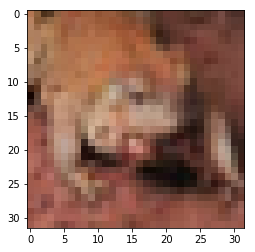

In [21]:
n = 5
if x_test.shape[-1] == 1:
    s = pp.shape
    pp = pp.reshape((s[0], s[1], s[2]))
    x_test = x_test.reshape((len(x_test), s[1], s[2]))
    
print(np.amax(x_test[n]), np.amax(pp[n]))
print(np.amin(x_test[n]), np.amin(pp[n]))
plt.imshow(x_test[n])

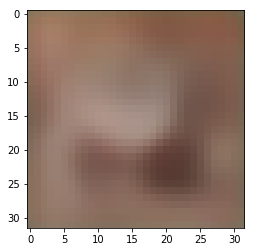

In [22]:
plt.imshow(pp[n])

In [35]:
'''This script demonstrates how to build a variational autoencoder
with Keras and deconvolution layers.

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Convolution2D, Deconvolution2D
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
nb_filters = 64
# convolution kernel size
nb_conv = 3

batch_size = 100
if K.image_dim_ordering() == 'th':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 0.01
nb_epoch = 2

x = Input(batch_shape=(batch_size,) + original_img_size)
conv_1 = Convolution2D(img_chns, 2, 2, border_mode='same', activation='relu')(x)
conv_2 = Convolution2D(nb_filters, 2, 2,
                       border_mode='same', activation='relu',
                       subsample=(2, 2))(conv_1)
conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv,
                       border_mode='same', activation='relu',
                       subsample=(1, 1))(conv_2)
conv_4 = Convolution2D(nb_filters, nb_conv, nb_conv,
                       border_mode='same', activation='relu',
                       subsample=(1, 1))(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(nb_filters * 14 * 14, activation='relu')

if K.image_dim_ordering() == 'th':
    output_shape = (batch_size, nb_filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, nb_filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Deconvolution2D(nb_filters, nb_conv, nb_conv,
                                   output_shape,
                                   border_mode='same',
                                   subsample=(1, 1),
                                   activation='relu')
decoder_deconv_2 = Deconvolution2D(nb_filters, nb_conv, nb_conv,
                                   output_shape,
                                   border_mode='same',
                                   subsample=(1, 1),
                                   activation='relu')
if K.image_dim_ordering() == 'th':
    output_shape = (batch_size, nb_filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, nb_filters)
decoder_deconv_3_upsamp = Deconvolution2D(nb_filters, 2, 2,
                                          output_shape,
                                          border_mode='valid',
                                          subsample=(2, 2),
                                          activation='relu')
decoder_mean_squash = Convolution2D(img_chns, 2, 2,
                                    border_mode='valid',
                                    activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

def vae_loss(x, x_decoded_mean):
    # NOTE: binary_crossentropy expects a batch_size by dim
    # for x and x_decoded_mean, so we MUST flatten these!
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (100, 28, 28, 1)      0                                            
____________________________________________________________________________________________________
convolution2d_39 (Convolution2D) (100, 28, 28, 1)      5           input_13[0][0]                   
____________________________________________________________________________________________________
convolution2d_40 (Convolution2D) (100, 14, 14, 64)     320         convolution2d_39[0][0]           
____________________________________________________________________________________________________
convolution2d_41 (Convolution2D) (100, 14, 14, 64)     36928       convolution2d_40[0][0]           
___________________________________________________________________________________________

In [36]:
# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train[:, :28, :28]
x_test = x_test[:, :28, :28]

print(x_train.shape)

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

(60000, 28, 28)
x_train.shape: (60000, 28, 28, 1)


In [37]:
vae.fit(x1, x1,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test), 
       verbose=0, callbacks=[TQDMNotebookCallback()])

269/|/[loss: nan]  45%|| 269/600 [00:19<00:06, 51.58it/s]

KeyboardInterrupt: 

In [ ]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n, x_train.shape[3]))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape((digit_size, digit_size, -1))
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()